In [258]:
import sqlite3
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
from pathFunc import dbPath, dataDir

In [259]:
conn = sqlite3.connect(dbPath())
query_burg = """SELECT * FROM table_name
WHERE "Crime Type" = "Burglary"
"""
query_sun = """SELECT * FROM sunlight"""
query_house = """SELECT * FROM housing_by_lsoa"""
query_unep = """SELECT * FROM montly_unemployement_claimant_count_by_lsoa_barnet"""

df_burglary_all = pd.read_sql(query_burg, conn)
df_sunlight_all = pd.read_sql(query_sun, conn)
df_housing_all = pd.read_sql(query_house, conn)
df_unemployment_all = pd.read_sql(query_unep, conn)
#getting data from database and storing in DF
conn.close()

In [260]:
start_year = 2013 #what data you will process
end_year = 2022
train_lower, train_upper = 2014, 2018 #what data you give the model to train
test_lower, test_upper = 2019, 2019 #test years for model

In [261]:
df_unemployment = df_unemployment_all.rename(columns={'geogcode': 'LSOA code'}) 
df_unemployment['Month'] =  pd.to_datetime(df_unemployment['date'])
df_unemployment_5yr = df_unemployment[(df_unemployment['Month'].dt.year >= start_year) & (df_unemployment['Month'].dt.year <= end_year)]
df_unemployment_5yr = df_unemployment_5yr[df_unemployment_5yr['LSOA code'] != 'Column Total']
df_unemployment_5yr["Unemployment"] = df_unemployment_5yr["value"]
df_unemployment_5yr = df_unemployment_5yr.drop(columns=["date", "index", "value"], axis=1)
#filterig unemployment to 5 year time spand of 2014 to 2019 and renaming columns for compatibility 
#2013 included for time lag

In [262]:

df_bar=df_burglary_all[df_burglary_all['LSOA name'].str.contains('Barnet')].drop(columns=['Reported by', 'Falls within']).dropna()
df_bar['Month'] = pd.to_datetime(df_bar['Month'])
df_bar['Year']= df_bar['Month'].dt.year
df_bar_5yr = df_bar[(df_bar['Month'].dt.year >= start_year) & (df_bar['Month'].dt.year <= end_year)]

#Filtering for Barnet data, 2013 included for time lag

In [263]:
df_sunlight_all['Month'] = pd.to_datetime(df_sunlight_all['Year-Month'])
df_sunlight=df_sunlight_all.drop(columns=["Year-Month", "index"], axis=1)
#Sunlight DF, ensuring compatibility by creating Datime Col


In [264]:
#df_housing = df_housing.drop(columns=["index"], axis=1)
#Housing dataframe
df_housing_clean = df_housing_all[["Proportion of indep", "Proportion small house", "Proportion social", "Proportion rented", "LSOA name",  "LSOA code" ]]

In [265]:
file_path =dataDir().joinpath("Household composition.xlsx")
df_grannies_all = pd.read_excel(file_path, sheet_name='2021')
df_grannies_all["Proportion old"]=df_grannies_all["One person Aged 66+"]/df_grannies_all['All households']
df_grannies=df_grannies_all[['LSOA code', 'One person Aged 66+', 'One person Aged up to 65','Family: all aged 66+', 'Proportion old']]

,LSOA code,One person Aged 66+,One person Aged up to 65,Family: all aged 66+,Proportion old
0,E01000001,126,245,84,0.150179
1,E01000002,101,309,59,0.121540
2,E01000003,161,422,31,0.157380
3,E01000005,47,172,7,0.098121
4,E01032739,18,406,7,0.020408
...,...,...,...,...,...
4989,E01035718,78,199,59,0.106122
4990,E01035719,50,218,22,0.079114
4991,E01035720,51,183,20,0.085714
4992,E01035721,139,616,42,0.106350


In [266]:
burglaries_per_lsoa_month = df_bar_5yr[df_bar_5yr['Crime type'] == 'Burglary'].groupby(['LSOA code', 'Month']).size()
burglaries_per_lsoa_month = burglaries_per_lsoa_month.reset_index(name='Total Burglaries')
#Getting total burglaries per LSOA on a Monthly basis

In [267]:
temp_merged = burglaries_per_lsoa_month.merge(df_housing_clean, how='left', on=['LSOA code']) #Merging Berg and Housing
temp_merged.fillna(temp_merged.mean(), inplace=True)
df_merged = temp_merged.merge(df_sunlight, how='left', on=['Month']) #Merging sunlight and (Housing+Burg)
df_merged_2 =  df_merged.merge(df_unemployment_5yr, how='left', on=['Month', 'LSOA code']) #Mergving pervious with unemployment
df_merged_3 = df_merged_2.merge(df_grannies, how='left', on='LSOA code')
temp_merged_clean = df_merged_3.drop(columns=['LSOA name']) #Drop unnecessary Cols
#temp_merged_clean
#len(df_merged_3['LSOA code'].unique())

C:\Users\shash\AppData\Local\Temp\ipykernel_28312\334127942.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  temp_merged.fillna(temp_merged.mean(), inplace=True)
C:\Users\shash\AppData\Local\Temp\ipykernel_28312\334127942.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  temp_merged.fillna(temp_merged.mean(), inplace=True)


In [268]:
lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # Giving Lag value in months
df = temp_merged_clean

for lag in lags:
    column_name_unep = f"Unemployment_PctChange_{lag}m"  # New column name for unemployment
    df[column_name_unep] = df.groupby('LSOA code')['Unemployment'].pct_change(periods=lag) * 100
    df[column_name_unep].replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf values with NaN

    column_name_burg = f"Total_Burglaries_PctChange_{lag}m"  # New column name for burglaries
    df[column_name_burg] = df.groupby('LSOA code')['Total Burglaries'].pct_change(periods=lag) * 100
    df[column_name_burg].replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf values with NaN

df.fillna(0, inplace=True)  # Replace remaining NaN values with zeros


In [270]:
# Create dummy variables for the 'LSOA code' column
dummy_df = pd.get_dummies(temp_merged_clean['LSOA code'], prefix='LSOA')

# Concatenate the dummy variables with the original DF
df_temp_merged_clean_dummies = pd.concat([temp_merged_clean, dummy_df], axis=1)
df_temp_merged_clean_dummies['Month_Int'] = df_temp_merged_clean_dummies['Month'].dt.month #Creating month int col
df_temp_merged_clean_dummies.head()

# Create dummy variables for the 'Month_Int' column
month_dummies = pd.get_dummies(df_temp_merged_clean_dummies['Month_Int'], prefix='Month')

# Concatenate the dummy variables with the original DataFrame
df_temp_merged_clean_dummies = pd.concat([df_temp_merged_clean_dummies, month_dummies], axis=1)
#df_temp_merged_clean_dummies.head()

In [271]:
df_temp_merged_clean_train = df_temp_merged_clean_dummies[(df_temp_merged_clean_dummies['Month'].dt.year >= train_lower) & (df_temp_merged_clean_dummies['Month'].dt.year <= train_upper)]
df_temp_merged_clean_test = df_temp_merged_clean_dummies[(df_temp_merged_clean_dummies['Month'].dt.year >= test_lower) & (df_temp_merged_clean_dummies['Month'].dt.year <= test_upper)]
#Filtering test and train based on time span provided in the 2nd cell

In [379]:
normal =["Total Burglaries", "LSOA code", "Month_Int", "Month", "Proportion small house", "One person Aged up to 65", "One person Aged 66+", "Family: all aged 66+"] #remove some for multicolinearity 
unep_lag_l = ["Unemployment_PctChange_2m" ,"Unemployment_PctChange_4m","Unemployment_PctChange_5m", "Unemployment_PctChange_6m", "Unemployment_PctChange_7m", "Unemployment_PctChange_8m", "Unemployment_PctChange_9m", "Unemployment_PctChange_10m", "Unemployment_PctChange_11m"]
burg_lag_l = ["Total_Burglaries_PctChange_4m","Total_Burglaries_PctChange_2m","Total_Burglaries_PctChange_5m","Total_Burglaries_PctChange_6m", "Total_Burglaries_PctChange_7m", "Total_Burglaries_PctChange_8m", "Total_Burglaries_PctChange_9m", "Total_Burglaries_PctChange_10m", "Total_Burglaries_PctChange_11m" ]
columns_drop = normal + unep_lag_l + burg_lag_l

In [380]:
X_train = df_temp_merged_clean_train.drop(columns=columns_drop) # What you give to the model
y_train = df_temp_merged_clean_train[["Total Burglaries"]] # What needs to be predicted

X_test = df_temp_merged_clean_test.drop(columns=columns_drop) # What you give to the model
y_test = df_temp_merged_clean_test[["Total Burglaries"]] # What needs to be predicted

In [381]:
X_train.head()

,Proportion of indep,Proportion social,Proportion rented,Sunlight,Unemployment,Proportion old,Unemployment_PctChange_1m,Total_Burglaries_PctChange_1m,Unemployment_PctChange_3m,Total_Burglaries_PctChange_3m,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
6,0.969072,0.0,0.09375,3.348560,10.0,0.104938,0.0,-50.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
7,0.969072,0.0,0.09375,4.691432,10.0,0.104938,0.0,0.0,0.0,-50.0,...,1,0,0,0,0,0,0,0,0,0
8,0.969072,0.0,0.09375,5.253036,10.0,0.104938,0.0,0.0,0.0,-50.0,...,0,1,0,0,0,0,0,0,0,0
9,0.969072,0.0,0.09375,7.468832,10.0,0.104938,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
10,0.969072,0.0,0.09375,4.597112,15.0,0.104938,50.0,0.0,50.0,0.0,...,0,0,0,0,0,0,1,0,0,0


In [382]:
model = XGBRegressor(n_estimators=100, reg_lambda = 1.5, alpha = 1)
model.fit(X_train, y_train)
#Fitting data to model

XGBRegressor(alpha=1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

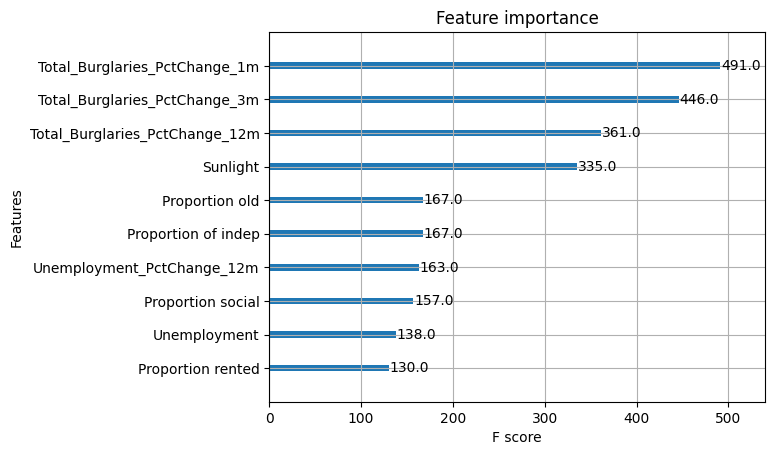

In [395]:
import matplotlib.pyplot as plt
%matplotlib inline
xgb.plot_importance(model, ax=plt.gca(), max_num_features=10)
#Plotting the most important featurs

In [384]:
pred_train = model.predict(X_train)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
predictions = model.predict(X_test)

In [385]:
# Calculate the train performance metrics
mse_train = mean_squared_error(y_train, pred_train)
mae_train = mean_absolute_error(y_train, pred_train)
r2_train = r2_score(y_train, pred_train)
medae_train = median_absolute_error(y_train, pred_train)

# Calculate the test performance metrics
mse_test = mean_squared_error(y_test, predictions)
mae_test = mean_absolute_error(y_test, predictions)
r2_test = r2_score(y_test, predictions)
medae_test = median_absolute_error(y_test, predictions)

# Create a dictionary with the train and test metric names and values
metrics = {
    'Metric': ['MSE', 'MAE', 'R^2', "MedAE"],
    'Train Value': [mse_train, mae_train, r2_train, medae_train],
    'Test Value': [mse_test, mae_test, r2_test, medae_test]
}

# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics)
metrics_df

,Metric,Train Value,Test Value
0,MSE,0.038892,0.159559
1,MAE,0.097154,0.169186
2,R^2,0.978815,0.907305
3,MedAE,0.049330,0.070098


In [386]:
df_date_lsoa_burg_temp = df_temp_merged_clean_test[['LSOA code', 'Month', 'Total Burglaries']].reset_index(drop=True, inplace=False)
predictions_df = pd.DataFrame(predictions, columns=['Prediction'])
predictions_df[['LSOA code', 'Month', 'Total Burglaries']] = df_date_lsoa_burg_temp
predictions_df

,Prediction,LSOA code,Month,Total Burglaries
0,1.941938,E01000115,2019-01-01,2
1,1.058450,E01000115,2019-02-01,1
2,3.087221,E01000115,2019-03-01,3
3,0.983252,E01000115,2019-04-01,1
4,1.099239,E01000115,2019-05-01,1
...,...,...,...,...
1754,1.947575,E01033572,2019-12-01,2
1755,1.164416,E01033573,2019-04-01,1
1756,2.034086,E01033573,2019-07-01,2
1757,2.997073,E01033573,2019-09-01,3


In [387]:
# Load your DataFrame
df = predictions_df

# Normalize the 'Prediction' column
df['Prediction_Normalized'] = (df['Prediction'] - df['Prediction'].mean()) / df['Prediction'].std()

# Normalize the 'Total Burglaries' column
df['Total_Burglaries_Normalized'] = (df['Total Burglaries'] - df['Total Burglaries'].mean()) / df['Total Burglaries'].std()

# Add a small amount of noise to ensure uniqueness
epsilon = 1e-8
df['Prediction_Normalized'] += np.random.uniform(-epsilon, epsilon, len(df))
df['Total_Burglaries_Normalized'] += np.random.uniform(-epsilon, epsilon, len(df))

# Calculate the severity levels based on the normalized values
df['Prediction_Severity_Norm'] = pd.qcut(df['Prediction_Normalized'], q=10, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
df['Burglaries_Severity_Norm'] = pd.qcut(df['Total_Burglaries_Normalized'], q=10, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Convert the severity columns to integer type
df['Prediction_Severity'] = df['Prediction_Severity_Norm'].astype(int)
df['Burglaries_Severity'] = df['Burglaries_Severity_Norm'].astype(int)


predictions_df


,Prediction,LSOA code,Month,Total Burglaries,Prediction_Normalized,Total_Burglaries_Normalized,Prediction_Severity_Norm,Burglaries_Severity_Norm,Prediction_Severity,Burglaries_Severity
0,1.941938,E01000115,2019-01-01,2,-0.060340,-0.019493,5,6,5,6
1,1.058450,E01000115,2019-02-01,1,-0.743696,-0.781471,2,2,2,2
2,3.087221,E01000115,2019-03-01,3,0.825508,0.742484,8,7,8,7
3,0.983252,E01000115,2019-04-01,1,-0.801859,-0.781471,0,3,0,3
4,1.099239,E01000115,2019-05-01,1,-0.712147,-0.781471,3,0,3,0
...,...,...,...,...,...,...,...,...,...,...
1754,1.947575,E01033572,2019-12-01,2,-0.055980,-0.019493,5,7,5,7
1755,1.164416,E01033573,2019-04-01,1,-0.661734,-0.781471,4,2,4,2
1756,2.034086,E01033573,2019-07-01,2,0.010934,-0.019493,6,4,6,4
1757,2.997073,E01033573,2019-09-01,3,0.755780,0.742484,7,8,7,8


In [388]:
X_test[0:1]

,Proportion of indep,Proportion social,Proportion rented,Sunlight,Unemployment,Proportion old,Unemployment_PctChange_1m,Total_Burglaries_PctChange_1m,Unemployment_PctChange_3m,Total_Burglaries_PctChange_3m,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
33,0.969072,0.0,0.09375,1.740893,5.0,0.104938,0.0,100.0,0.0,-50.0,...,0,0,0,0,0,0,0,0,0,0


In [389]:
model.predict(X_test[0:1])



array([1.9419377], dtype=float32)

In [390]:
y_test[0:1]

,Total Burglaries
33,2


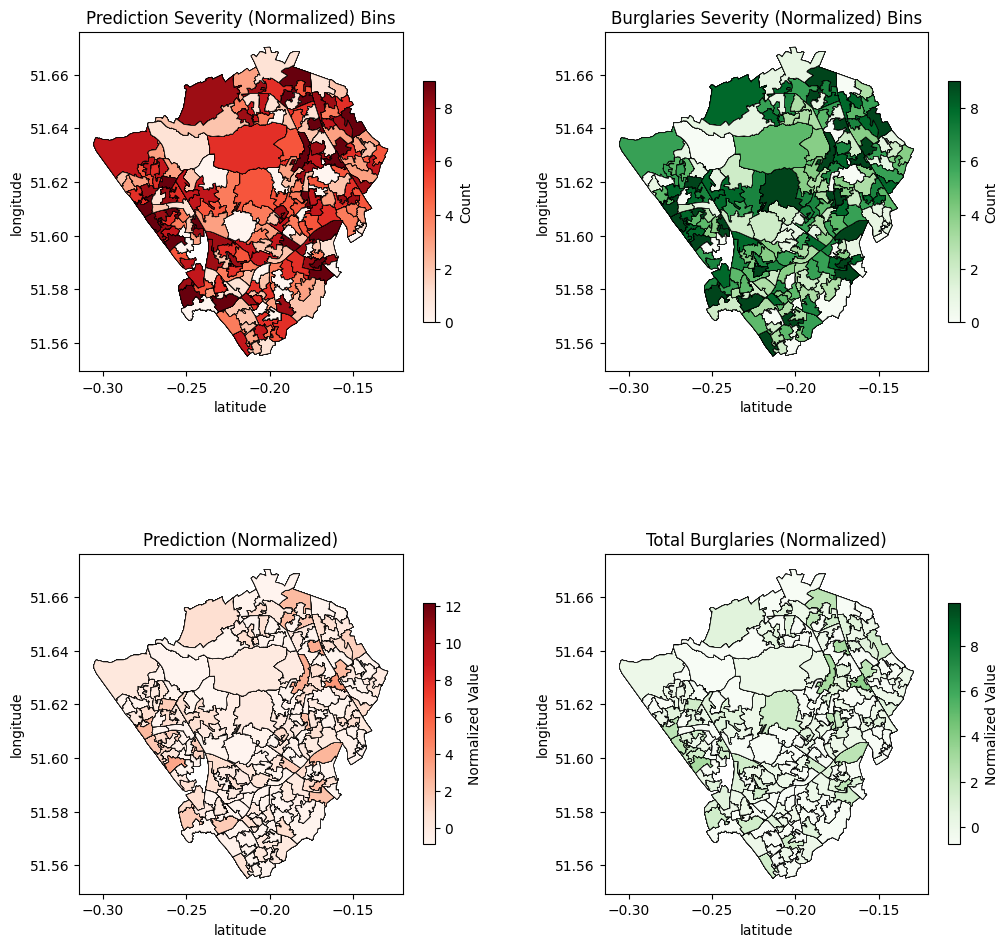

In [391]:
import geopandas as gpd
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Load the GeoJSON file containing LSOA boundaries and extract the necessary columns
geo_LSOA = gpd.read_file(dataDir().joinpath('files_for_map/barnet_lsoa.geojson'))
geo_LSOA = geo_LSOA[['geometry', 'lsoa11cd']]
geo_LSOA.rename(columns={'lsoa11cd': 'LSOA code'}, inplace=True)

# Merge the LSOA data with the predictions DataFrame
counts_per_LSOA = predictions_df
merged_cpl_geo = pd.merge(geo_LSOA, counts_per_LSOA, on=['LSOA code'])

# Create subplots for 2x2 visualization
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot the first map - Prediction_Severity_Norm
merged_cpl_geo.plot(column='Prediction_Severity_Norm', cmap='Reds', edgecolor='black', linewidth=0.5, ax=axs[0, 0])
axs[0, 0].set_title('Prediction Severity (Normalized) Bins')
sm1 = plt.cm.ScalarMappable(cmap='Reds')
sm1.set_array(merged_cpl_geo['Prediction_Severity_Norm'])
cbar1 = plt.colorbar(sm1, orientation='vertical', shrink=0.6, ax=axs[0, 0])
cbar1.set_label('Count')
axs[0, 0].set_xlabel('latitude')
axs[0, 0].set_ylabel('longitude')

# Plot the second map - Burglaries_Severity_Norm
merged_cpl_geo.plot(column='Burglaries_Severity_Norm', cmap='Greens', edgecolor='black', linewidth=0.5, ax=axs[0, 1])
axs[0, 1].set_title('Burglaries Severity (Normalized) Bins')
sm2 = plt.cm.ScalarMappable(cmap='Greens')
sm2.set_array(merged_cpl_geo['Burglaries_Severity_Norm'])
cbar2 = plt.colorbar(sm2, orientation='vertical', shrink=0.6, ax=axs[0, 1])
cbar2.set_label('Count')
axs[0, 1].set_xlabel('latitude')
axs[0, 1].set_ylabel('longitude')

# Plot the third map - Prediction_Normalized
merged_cpl_geo.plot(column='Prediction_Normalized', cmap='Reds', edgecolor='black', linewidth=0.5, ax=axs[1, 0])
axs[1, 0].set_title('Prediction (Normalized)')
sm3 = plt.cm.ScalarMappable(cmap='Reds')
sm3.set_array(merged_cpl_geo['Prediction_Normalized'])
cbar3 = plt.colorbar(sm3, orientation='vertical', shrink=0.6, ax=axs[1, 0])
cbar3.set_label('Normalized Value')
axs[1, 0].set_xlabel('latitude')
axs[1, 0].set_ylabel('longitude')

# Plot the fourth map - Total_Burglaries_Normalized
merged_cpl_geo.plot(column='Total_Burglaries_Normalized', cmap='Greens', edgecolor='black', linewidth=0.5, ax=axs[1, 1])
axs[1, 1].set_title('Total Burglaries (Normalized)')
sm4 = plt.cm.ScalarMappable(cmap='Greens')
sm4.set_array(merged_cpl_geo['Total_Burglaries_Normalized'])
cbar4 = plt.colorbar(sm4, orientation='vertical', shrink=0.6, ax=axs[1, 1])
cbar4.set_label('Normalized Value')
axs[1, 1].set_xlabel('latitude')
axs[1, 1].set_ylabel('longitude')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Show the plot
plt.show()


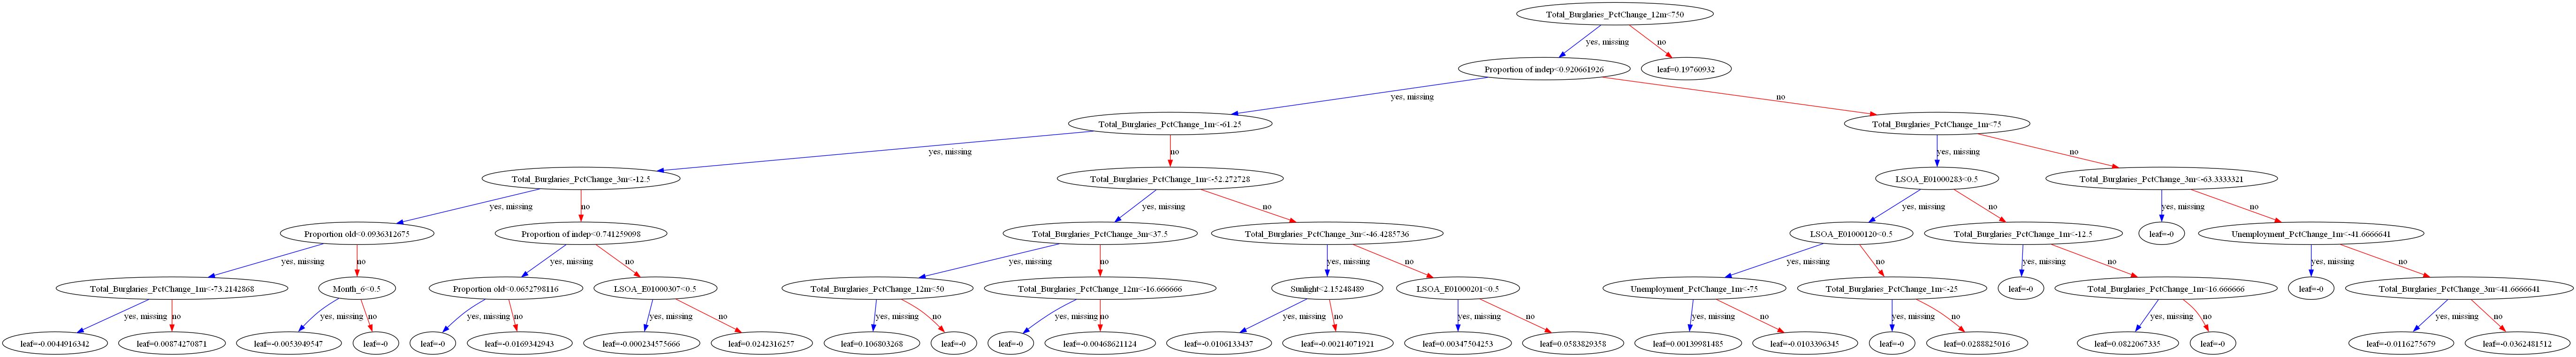

In [392]:
import xgboost as xgb
import pydot
from IPython.display import Image

# Convert a single tree to DOT format
tree = xgb.to_graphviz(model, num_trees=1)
tree.format = 'png'  # Set the output format (e.g., png, pdf, svg)

# Save the tree as an image
tree.render("tree")  # Specify the output file name and DPI

# Display the saved image
Image(filename="tree.png")
